# Component Sankey Diagram


In [1]:
import pprint
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import copy
from energysys_components.energy_conversion import ECCParameter, ECCState,EnergyConversionComponent
from energysys_components.various.sankey import sankey_component_input_dicts
from pathlib import Path
from energysys_components.energy_carrier import ECarrier


## System initialization

In [2]:
path_ecarrier = Path.cwd().parent / Path("energycarrier/energycarrier.yaml")
ec_dict = ECarrier.from_yaml(path_ecarrier)
components = ECCParameter.from_yaml(Path.cwd() / Path("../components/fuel_cell_PEM.yaml"), ecarrier=ec_dict)
component = components["PEM"]

## Calculation of stationary states

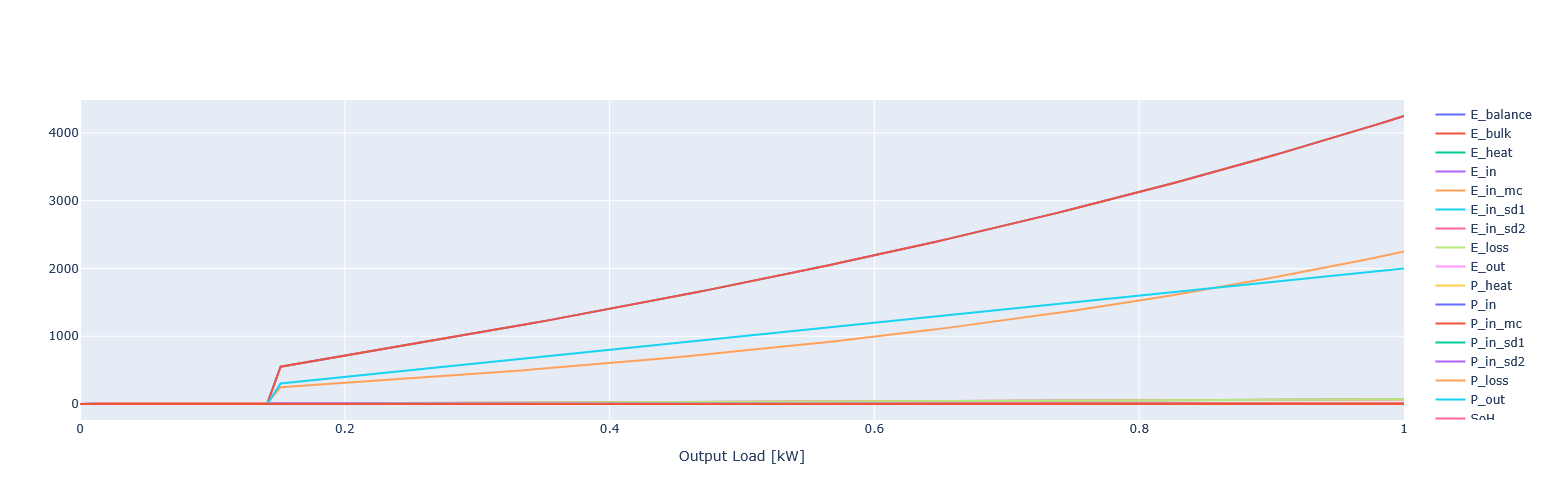

In [3]:
# Result DataFrame Initialization
state_parms = [a for a in dir(ECCState()) if not a.startswith('__')]
df1 = pd.DataFrame(columns=state_parms)
df1.loc[0] = vars(ECCState())

# Run different stationary cases for target output load
targets = np.linspace(0, 1., 100)

for ct, t in enumerate(targets):
    # Initialization of component
    C1_state = ECCState()
    C1 = EnergyConversionComponent(par=component,
                                   ts=1,
                                   state=copy.deepcopy(C1_state))
    C1.step_action_stationary(t)
    df1.loc[ct + 1] = vars(C1.state)
    df1.loc[ct + 1, "Target"] = t

# Create traces
fig = go.Figure()

# Create traces
for cl in df1.columns:
    fig.add_trace(go.Scatter(x=df1.Target[1:], y=df1[cl][1:],
                             mode='lines',
                             name=cl))
fig.update_layout(xaxis_title="Output Load [kW]",
                  # yaxis_title="Y Axis Title",
                  )
fig.update_layout(
    autosize=False,
    width=1400,
    height=500)
fig.show()

### Sankey Chart

In [4]:
# Select result case
data = df1.iloc[-2]

In [5]:
path_ecarrier = Path.cwd().parent / Path("energycarrier/energycarrier.yaml")
ec_dict = ECarrier.from_yaml(path_ecarrier)

In [6]:
ec_dict

{'NH3': ECarrier(name='Ammonia', hu_kWh_kg=5.2, density_liq_kg_m3=682.78, energy_density_liq_kWh_m3=3550.456, color='#19a844'),
 'H2': ECarrier(name='Hydrogen', hu_kWh_kg=33.33, density_liq_kg_m3=70.79, energy_density_liq_kWh_m3=2359.4307, color='#1982a8'),
 'LNG': ECarrier(name='LNG', hu_kWh_kg=13.98, density_liq_kg_m3=450, energy_density_liq_kWh_m3=6291, color='#1982a8'),
 'Electr': ECarrier(name='Electricity', hu_kWh_kg=0, density_liq_kg_m3=0, energy_density_liq_kWh_m3=0, color='#ccb80e'),
 'Loss': ECarrier(name='Loss', hu_kWh_kg=0, density_liq_kg_m3=0, energy_density_liq_kWh_m3=0, color='#cc470e'),
 'Seawater': ECarrier(name='Seawater', hu_kWh_kg=0, density_liq_kg_m3=999, energy_density_liq_kWh_m3=0, color='#0e8acc')}

In [7]:


# Create plotly formatted input
data_node, data_link = sankey_component_input_dicts(data,
                                                    comp=component,
                                                    energycarrier=ec_dict)

fig = go.Figure(data=[go.Sankey(
    valueformat=".0f",
    valuesuffix="kW",
    # Define nodes
    node=dict(
        pad=15,
        thickness=40,
        line=dict(color="black", width=0.5),
        label=data_node['label'],
        color=data_node['color']),
    link=data_link)])

fig.update_layout(
    title_text=f"Simple component sankey diagram for component {component.name}",
    font_size=10)
fig.show()

## Load cycle calculation

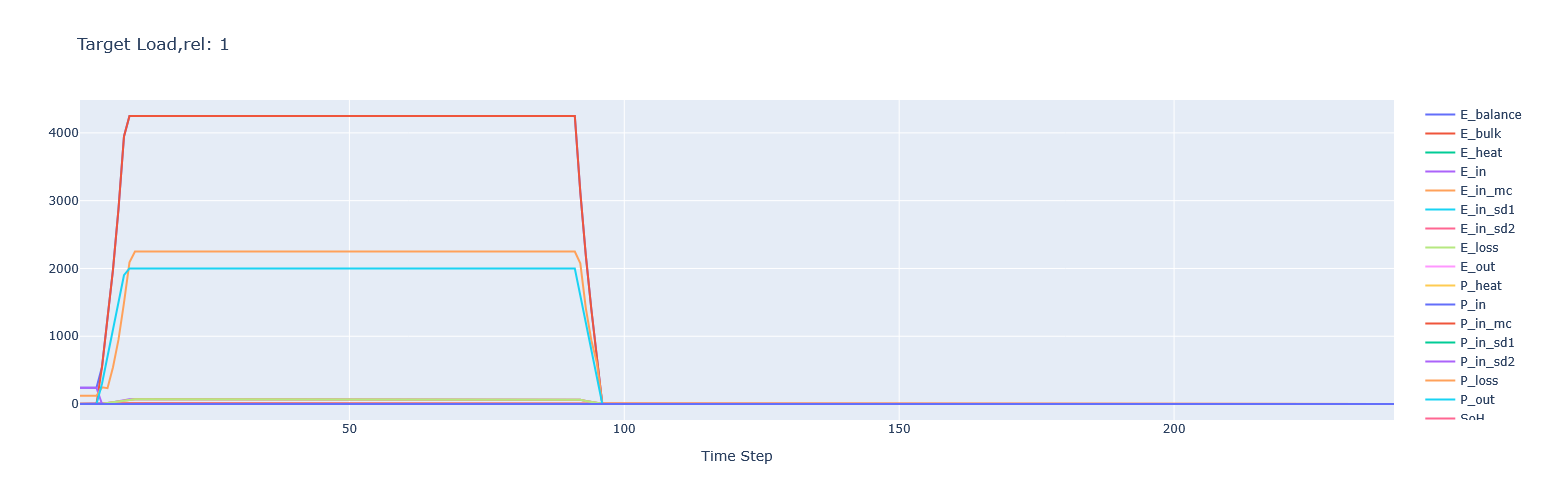

In [8]:
# Result DataFrame Initialization
state_parms = [a for a in dir(ECCState()) if not a.startswith('__')]
df1 = pd.DataFrame(columns=state_parms)
df1.loc[0] = vars(ECCState())

# Run different stationary cases for target output load
target = 1

# number of time steps
ts = 240

## Initialization of component
C1_state = ECCState()
C1 = EnergyConversionComponent(par=component,
                               ts=1,
                               state=copy.deepcopy(C1_state))
for t in range(ts):
    if t <= 90:
        C1.step_action(target)
    else:
        C1.step_action(0)
    df1.loc[t + 1] = vars(C1.state)

# Create traces
fig = go.Figure()

# Create traces
for cl in df1.columns:
    fig.add_trace(go.Scatter(x=df1.index[1:], y=df1[cl][1:],
                             
                             mode='lines',
                             name=cl))
    
fig.update_layout(title=f"Target Load,rel: {target}",
                  xaxis_title="Time Step",
                 )
fig.update_layout(
    autosize=False,
    width=1400,
    height=500)
fig.show()

### Sankey Diagrams

In [11]:
from dash import Dash, dcc, html, Input, Output
import plotly.graph_objects as go
import json, urllib

app = Dash(__name__)

app.layout = html.Div([
    dcc.Graph(id="graph"),
    html.P("TS"),
    dcc.Slider(id='slider', min=0, max=240, 
               value=90,marks=None, step=1)
])

@app.callback(
    Output("graph", "figure"), 
    Input("slider", "value"))
def display_sankey(ts):
    # Create plotly formatted input
    data = df1.iloc[ts]
    data_node, data_link = sankey_component_input_dicts(data,
                                                        comp=component,
                                                       energycarrier=ec_dict)
    
    fig = go.Figure(data=[go.Sankey(
        valueformat=".0f",
        valuesuffix="kW",
        # Define nodes
        node=dict(
            pad=15,
            thickness=40,
            line=dict(color="black", width=0.5),
            #label=data_node['label'],
            color=data_node['color']),
        link=data_link)])
    
    # fig.update_layout(
    #     title_text=f"Component sankey diagram for component: {component.name}",
    #     font_size=10)

    fig.update_layout(
        autosize=False,
        width=400,
        height=300)

    fig.update_layout(
    plot_bgcolor='#F2F2F2',
    paper_bgcolor='#F2F2F2',
)
    
    return fig
app.run(debug=True)